In [31]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import roc_auc_score

In [2]:
import train_model as tm
import visualize as vis
import build_features as bf
import make_dataset as md

In [3]:
# set random state
rand_state = 1

# Load files into memory

In [4]:
counts_filename = 'data/count_data_species_raw_WIS_overlapping_fungi_bacteria_12773samples.tsv'
metadata_filename = 'data/metadata_species_WIS_overlapping_fungi_bacteria_12773samples.tsv'

In [5]:
counts = md.read_fungi_data(counts_filename)
metadata = md.read_fungi_data(metadata_filename)

In [6]:
# consider selecting metadata columns before combining
combined = pd.merge(metadata, counts, on="sampleid", how="inner")

In [7]:
metadata.columns

Index(['sample_name', 'run_prefix', 'experimental_strategy', 'cgc_base_name',
       'filename', 'analyte_amount', 'analyte_A260A280Ratio',
       'aliquot_concentration', 'cgc_id', 'cgc_filename', 'vital_status',
       'gender', 'race', 'ethnicity', 'disease_type', 'data_subtype',
       'tcga_sample_id', 'cgc_case_uuid', 'sample_type', 'cgc_platform',
       'gdc_file_uuid', 'primary_site', 'age_at_diagnosis', 'cgc_sample_uuid',
       'cgc_aliquot_uuid', 'tcga_aliquot_id', 'reference_genome',
       'tcga_case_id', 'investigation', 'days_to_death', 'knightlabID',
       'data_submitting_center_label', 'tissue_source_site_label',
       'country_of_sample_procurement', 'portion_is_ffpe',
       'pathologic_t_label', 'pathologic_n_label',
       'histological_diagnosis_label', 'pathologic_stage_label', 'PlateCenter',
       'PlateCenterFlag'],
      dtype='object')

In [8]:
metadata.head()

,sample_name,run_prefix,experimental_strategy,cgc_base_name,filename,analyte_amount,analyte_A260A280Ratio,aliquot_concentration,cgc_id,cgc_filename,...,data_submitting_center_label,tissue_source_site_label,country_of_sample_procurement,portion_is_ffpe,pathologic_t_label,pathologic_n_label,histological_diagnosis_label,pathologic_stage_label,PlateCenter,PlateCenterFlag
sampleid,,,,,,,,,,,,,,,,,,,,,
13722.58cfa82de4b0c9d6adf6a4c2,58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.filtered.,WGS,12dd02ea14d0a87df23ce3bef406fe27,12dd02ea14d0a87df23ce3bef406fe27.bam,32.75,NaN,0.08,58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.bam,...,Washington University School of Medicine,Duke,United States,NO,T2,N0,Infiltrating Ductal Carcinoma,Stage IIA,A21Q-09,True
13722.58cfa82de4b0c9d6adf6a502,58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.filtered.,WGS,3d9f475186150ea055fddf25af7bb7e3,3d9f475186150ea055fddf25af7bb7e3.bam,64.35,1.70,0.08,58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.bam,...,Washington University School of Medicine,University of North Carolina,United States,NO,Not available,Not available,Endometrioid endometrial adenocarcinoma,Not available,A13L-09,False
13722.58cfa82de4b0c9d6adf6a4ce,58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.filtered.,WGS,2258e57e8e0af9db6969a1da86177ca7,2258e57e8e0af9db6969a1da86177ca7.bam,62.02,2.08,0.08,58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.bam,...,Washington University School of Medicine,MSKCC,None,NO,T3,N2,Infiltrating Ductal Carcinoma,Stage IIIA,A19H-09,True
13722.58cfa82de4b0c9d6adf6a48a,58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.filtered.,WGS,142ba22e796cab1075278cd533a287c8,142ba22e796cab1075278cd533a287c8.bam,93.54,2.18,0.07,58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.bam,...,Washington University School of Medicine,MSKCC,None,NO,Not available,Not available,Serous endometrial adenocarcinoma,Not available,A066-09,True
13722.58cfa82de4b0c9d6adf6a4d4,58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.filtered.,WGS,406aecbc23505359850e57fbf05d5b67,406aecbc23505359850e57fbf05d5b67.bam,85.32,1.85,0.08,58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.bam,...,Washington University School of Medicine,MSKCC,None,NO,Not available,Not available,Serous endometrial adenocarcinoma,Not available,A066-09,True


In [9]:
counts.head()

,Actinomyces_dentalis,Actinomyces_johnsonii,Actinomyces_massiliensis,Actinomyces_naeslundii,Actinomyces_oris,Actinomyces_viscosus,Mobiluncus_curtisii,Alloscardovia_omnicolens,Bifidobacterium_adolescentis,Bifidobacterium_animalis,...,Stereum_hirsutum,Tilletiopsis_washingtonensis,Malassezia_globosa,Malassezia_restricta,Malassezia_sympodialis,Rhodotorula_graminis,Trichosporon_asahii,Pseudozyma_hubeiensis,Sporisorium_graminicola,Wallemia_ichthyophaga
sampleid,,,,,,,,,,,,,,,,,,,,,
13722.58cfa82de4b0c9d6adf6a4c2,0,4,4,6,10,1,0,0,0,0,...,0,0,13628,98,2,0,0,0,0,0
13722.58cfa82de4b0c9d6adf6a502,2,11,2,5,16,4,0,0,0,0,...,0,0,3003,121,0,0,0,0,0,0
13722.58cfa82de4b0c9d6adf6a4ce,0,7,4,1,7,1,1,0,0,0,...,2,0,9497,169,0,1,0,1,3,0
13722.58cfa82de4b0c9d6adf6a48a,0,0,2,2,14,0,2,0,0,0,...,5,0,14486,783,6,0,0,0,1,0
13722.58cfa82de4b0c9d6adf6a4d4,0,0,0,0,0,0,1,0,0,0,...,4,0,15702,85,0,0,0,0,2,0


In [10]:
combined.head()

,sample_name,run_prefix,experimental_strategy,cgc_base_name,filename,analyte_amount,analyte_A260A280Ratio,aliquot_concentration,cgc_id,cgc_filename,...,Stereum_hirsutum,Tilletiopsis_washingtonensis,Malassezia_globosa,Malassezia_restricta,Malassezia_sympodialis,Rhodotorula_graminis,Trichosporon_asahii,Pseudozyma_hubeiensis,Sporisorium_graminicola,Wallemia_ichthyophaga
sampleid,,,,,,,,,,,,,,,,,,,,,
13722.58cfa82de4b0c9d6adf6a4c2,58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.filtered.,WGS,12dd02ea14d0a87df23ce3bef406fe27,12dd02ea14d0a87df23ce3bef406fe27.bam,32.75,NaN,0.08,58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.bam,...,0,0,13628,98,2,0,0,0,0,0
13722.58cfa82de4b0c9d6adf6a502,58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.filtered.,WGS,3d9f475186150ea055fddf25af7bb7e3,3d9f475186150ea055fddf25af7bb7e3.bam,64.35,1.70,0.08,58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.bam,...,0,0,3003,121,0,0,0,0,0,0
13722.58cfa82de4b0c9d6adf6a4ce,58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.filtered.,WGS,2258e57e8e0af9db6969a1da86177ca7,2258e57e8e0af9db6969a1da86177ca7.bam,62.02,2.08,0.08,58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.bam,...,2,0,9497,169,0,1,0,1,3,0
13722.58cfa82de4b0c9d6adf6a48a,58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.filtered.,WGS,142ba22e796cab1075278cd533a287c8,142ba22e796cab1075278cd533a287c8.bam,93.54,2.18,0.07,58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.bam,...,5,0,14486,783,6,0,0,0,1,0
13722.58cfa82de4b0c9d6adf6a4d4,58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.filtered.,WGS,406aecbc23505359850e57fbf05d5b67,406aecbc23505359850e57fbf05d5b67.bam,85.32,1.85,0.08,58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.bam,...,4,0,15702,85,0,0,0,0,2,0


In [11]:
metadata.shape

(12773, 41)

In [12]:
counts.shape

(12773, 297)

In [13]:
combined.shape

(12773, 338)

In [14]:
combined["days_to_death"].value_counts()

0.0       14
270.0     13
709.0     12
457.0     11
415.0     11
          ..
1149.0     1
1588.0     1
740.0      1
912.0      1
1714.0     1
Name: days_to_death, Length: 1123, dtype: int64

In [15]:
combined["days_to_death"].mean()

940.4683794466404

In [16]:
# note 76% of samples dont have DTD
combined["days_to_death"].isna().mean()

0.7623111250293588

In [17]:
# 3036 data points to work with
combined["days_to_death"].notna().sum()

3036

{'whiskers': [<matplotlib.lines.Line2D at 0x1d5e96ea640>,
 'caps': [<matplotlib.lines.Line2D at 0x1d5e96eabe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d5e948e1c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d5e97081c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d5e9708490>],
 'means': []}

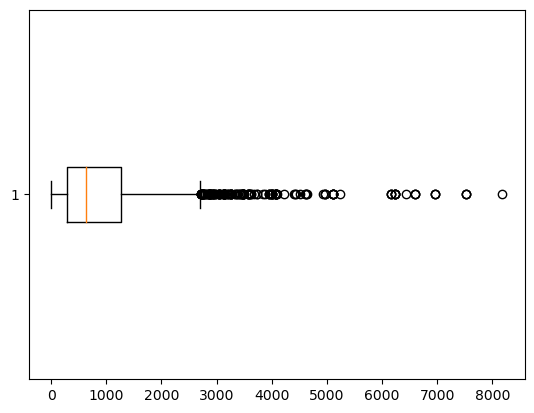

In [18]:
# drop nans + values < 10k
plt.boxplot(combined[combined['days_to_death'] < 10_000]['days_to_death'].dropna(), vert=False)

## Searching for metadata features

In [19]:
len(metadata.columns)

41

In [20]:
metadata[metadata.columns[1:10]].head()
# important columns
# [experimental_strategy]
# what the hell are these
# [analyte_amount, analyte_A260A280Ratio, aliquot_concentration]

,run_prefix,experimental_strategy,cgc_base_name,filename,analyte_amount,analyte_A260A280Ratio,aliquot_concentration,cgc_id,cgc_filename
sampleid,,,,,,,,,
13722.58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.filtered.,WGS,12dd02ea14d0a87df23ce3bef406fe27,12dd02ea14d0a87df23ce3bef406fe27.bam,32.75,NaN,0.08,58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.bam
13722.58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.filtered.,WGS,3d9f475186150ea055fddf25af7bb7e3,3d9f475186150ea055fddf25af7bb7e3.bam,64.35,1.70,0.08,58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.bam
13722.58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.filtered.,WGS,2258e57e8e0af9db6969a1da86177ca7,2258e57e8e0af9db6969a1da86177ca7.bam,62.02,2.08,0.08,58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.bam
13722.58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.filtered.,WGS,142ba22e796cab1075278cd533a287c8,142ba22e796cab1075278cd533a287c8.bam,93.54,2.18,0.07,58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.bam
13722.58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.filtered.,WGS,406aecbc23505359850e57fbf05d5b67,406aecbc23505359850e57fbf05d5b67.bam,85.32,1.85,0.08,58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.bam


In [21]:
metadata[metadata.columns[11:20]].head()
# important columns
# [gender, race, ethnicity, disease_type, sample_type]
# what the hell are these
# [data_subtype, cgc_platform]

,gender,race,ethnicity,disease_type,data_subtype,tcga_sample_id,cgc_case_uuid,sample_type,cgc_platform
sampleid,,,,,,,,,
13722.58cfa82de4b0c9d6adf6a4c2,FEMALE,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,Breast Invasive Carcinoma,Aligned reads,TCGA-B6-A0I1-01A,5DD423E8-FEAA-4568-A750-500948C41D6C,Primary Tumor,Illumina HiSeq
13722.58cfa82de4b0c9d6adf6a502,FEMALE,WHITE,HISPANIC OR LATINO,Uterine Corpus Endometrial Carcinoma,Aligned reads,TCGA-EY-A1GW-01A,F8AC5FD2-11F2-4B3A-A3A6-FF1A6D8E1CAE,Primary Tumor,Illumina HiSeq
13722.58cfa82de4b0c9d6adf6a4ce,FEMALE,ASIAN,NOT HISPANIC OR LATINO,Breast Invasive Carcinoma,Aligned reads,TCGA-AO-A03L-01A,1174F6E4-FFBE-4E59-A000-8D861C968369,Primary Tumor,Illumina HiSeq
13722.58cfa82de4b0c9d6adf6a48a,FEMALE,WHITE,Not available,Uterine Corpus Endometrial Carcinoma,Aligned reads,TCGA-AP-A0L9-01A,7B9947D5-E86B-4006-8890-EA5209584A88,Primary Tumor,Illumina HiSeq
13722.58cfa82de4b0c9d6adf6a4d4,FEMALE,BLACK OR AFRICAN AMERICAN,Not available,Uterine Corpus Endometrial Carcinoma,Aligned reads,TCGA-AP-A0LI-01A,E1E8DC66-467C-48A5-BE56-3DB4F665B9F1,Primary Tumor,Illumina HiSeq


In [22]:
metadata[metadata.columns[21:30]].head()
# important columns
# [primary_site, days_to_death]
# what the hell are these
# [reference_genome, investigation]

,primary_site,age_at_diagnosis,cgc_sample_uuid,cgc_aliquot_uuid,tcga_aliquot_id,reference_genome,tcga_case_id,investigation,days_to_death
sampleid,,,,,,,,,
13722.58cfa82de4b0c9d6adf6a4c2,Breast,73.0,2A5F4696-6E02-4FE9-B66D-8C2AE93B7C2F,2290B078-6A5B-4C83-9DFB-B525BBF14E4E,TCGA-B6-A0I1-01A-11D-A21Q-09,GRCh37-lite,TCGA-B6-A0I1,TCGA-BRCA,2361.0
13722.58cfa82de4b0c9d6adf6a502,Uterus,73.0,22CB3D87-7FAB-419A-B071-1ADC6B810719,EC31E921-0782-4F77-AC23-4190AF1E61EE,TCGA-EY-A1GW-01A-22D-A13L-09,GRCh37-lite,TCGA-EY-A1GW,TCGA-UCEC,NaN
13722.58cfa82de4b0c9d6adf6a4ce,Breast,34.0,00F81E98-E5C3-43B2-9757-F769EC17F3F8,8F558713-F32B-403B-AEDF-C79EFEB41C67,TCGA-AO-A03L-01A-41D-A19H-09,GRCh37-lite,TCGA-AO-A03L,TCGA-BRCA,NaN
13722.58cfa82de4b0c9d6adf6a48a,Uterus,71.0,53D0521F-10D6-4F70-9277-D99025A6B963,2B78DE4E-4C8B-4ADF-A058-3DAE797E7881,TCGA-AP-A0L9-01A-11D-A066-09,GRCh37-lite,TCGA-AP-A0L9,TCGA-UCEC,NaN
13722.58cfa82de4b0c9d6adf6a4d4,Uterus,67.0,981D9E3B-63C5-41E9-827F-7F1D268D62F4,DEC775C5-7D9A-4DC5-B399-DC4B7BA49D73,TCGA-AP-A0LI-01A-11D-A066-09,GRCh37-lite,TCGA-AP-A0LI,TCGA-UCEC,NaN


In [23]:
metadata[metadata.columns[31:41]].head()
# important columns
# [data_submitting_center_label, tissue_source_site_label, country_of_sample_procurement, pathologic_stage_label]
# what the hell are these
# [portion_is_ffpe, pathologic_t_label, pathologic_n_label, histological_diagnosis_label, PlateCenter, PlateCenterFlag]

,data_submitting_center_label,tissue_source_site_label,country_of_sample_procurement,portion_is_ffpe,pathologic_t_label,pathologic_n_label,histological_diagnosis_label,pathologic_stage_label,PlateCenter,PlateCenterFlag
sampleid,,,,,,,,,,
13722.58cfa82de4b0c9d6adf6a4c2,Washington University School of Medicine,Duke,United States,NO,T2,N0,Infiltrating Ductal Carcinoma,Stage IIA,A21Q-09,True
13722.58cfa82de4b0c9d6adf6a502,Washington University School of Medicine,University of North Carolina,United States,NO,Not available,Not available,Endometrioid endometrial adenocarcinoma,Not available,A13L-09,False
13722.58cfa82de4b0c9d6adf6a4ce,Washington University School of Medicine,MSKCC,None,NO,T3,N2,Infiltrating Ductal Carcinoma,Stage IIIA,A19H-09,True
13722.58cfa82de4b0c9d6adf6a48a,Washington University School of Medicine,MSKCC,None,NO,Not available,Not available,Serous endometrial adenocarcinoma,Not available,A066-09,True
13722.58cfa82de4b0c9d6adf6a4d4,Washington University School of Medicine,MSKCC,None,NO,Not available,Not available,Serous endometrial adenocarcinoma,Not available,A066-09,True


## Metadata Regression

In [24]:
important_cols = ['experimental_strategy', 'gender', 'race', 'ethnicity', 
'disease_type', 'sample_type','primary_site', 'days_to_death','data_submitting_center_label', 
'tissue_source_site_label', 'country_of_sample_procurement', 'pathologic_stage_label']

In [25]:
metadata['pathologic_stage_label'].value_counts()
# experimental_strategy          - ohe
# gender                         - ohe
# race                           - ohe
# ethnicity                      - ohe
# disease_type                   - ohe
# sample_type                    - ohe (possibly assign numerical? are they ordinal?)
# primary_site                   - ohe
# data_submitting_center_label   - ohe
# tissue_source_site_label       - avoid ohe (179 unique vals)
# country_of_sample_procurement  - ohe
# pathologic_stage_label         - ohe (reduce stages)


# days_to_death             - numerical

Not available    4057
Stage I          1621
Stage III         969
Stage IIA         910
Stage II          817
Stage IIB         796
Stage IV          716
Stage IIIA        674
Stage IB          571
Stage IA          460
Stage IIIB        384
Stage IIIC        304
Stage IVA         259
Stage IIC          74
Stage IS           33
I or II NOS        21
Stage IVC          20
Stage IVB          14
Stage X            12
Stage 0             5
Stage Tis           1
Name: pathologic_stage_label, dtype: int64

## Regression Model

In [26]:
reg_data = combined[combined["days_to_death"].notna()]

In [27]:
reg_data.shape

(3036, 338)

In [28]:
# separate X and Y and generate 

test_prop = 0.1
reg_X = reg_data.drop(columns=metadata.columns)
reg_Y = reg_data["days_to_death"]
reg_Xtrain, reg_Xtest, reg_Ytrain, reg_Ytest = train_test_split(reg_X, reg_Y, test_size=test_prop, random_state=rand_state)

In [29]:
reg_model = sk.linear_model.LinearRegression()
reg_model.fit(reg_Xtrain, reg_Ytrain)
preds = reg_model.predict(reg_Xtest)
preds = [x if x > 0 else 0 for x in preds] # Replace negative predictions
scores = mean_squared_error(reg_Ytest, preds)
scores

147401407.4229222

In [30]:
(reg_Ytest - preds).head()

sampleid
13722.58cfa82de4b0c9d6adf6a6d6   -248.756802
13767.58cfa837e4b0c9d6adf6ff58   -827.699620
13722.58cfa831e4b0c9d6adf6c594   -775.038069
13722.58cfa830e4b0c9d6adf6c266   -347.895133
13722.58cfa831e4b0c9d6adf6c6b8     92.074162
Name: days_to_death, dtype: float64

## Classification Model

In [32]:
# taken from train_model and modified for this task

def model_predict(dataset, cancer_stages):
    '''Take in as input the cleaned datasets of the features(X) and the one-hot encoded cancer stages/targets(Y)
       then perform 10-fold validation split and use them to train the model.
       
       Output: Auroc and Aupr scores of the model
       
    '''
    
    # define cross validation hyperparams
    n_splits = 10
    skf_random = 0 #DO NOT TOUCH
    shuffle=True
    # define model hyperparams, can automate tuning later
    loss = 'exponential'
    learning_rate = 0.1
    n_estimators = 150
    max_depth = 3
    clf_random = 0 #DO NOT TOUCH
   
    skf = StratifiedKFold(n_splits=n_splits, random_state=skf_random, shuffle=shuffle)

    clf = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, random_state=clf_random)
    
    for i, stage in enumerate(cancer_stages.columns, start=1):
        X = dataset
        y = cancer_stages[stage]
        
        auroc_plt_data = np.array([])
        aupr_plt_data = np.array([])
        
        for train_index, val_index in skf.split(X, y):
            train_X, train_y = X.iloc[train_index], y.iloc[train_index]
            val_X, val_y = X.iloc[val_index], y.iloc[val_index]

            clf.fit(train_X, train_y) #re-fit model
            
            preds = clf.predict_proba(val_X)[:,1] #predict, probability of positive class predict

            auroc = roc_auc_score(val_y, preds) #TODO: implement separate score function to return multiple scores
            aupr = average_precision_score(val_y, preds)
            
            auroc_plt_data = np.append(auroc_plt_data, auroc)
            aupr_plt_data = np.append(aupr_plt_data, aupr)
    
    return auroc_plt_data, aupr_plt_data

In [ ]:
# Week 3 todo
# make wrapper function to process dataset into format to input into model_predict()
    # OHE and combine cancer substages
    # create feature matrix (basically just removing y var)
    # plot auroc and aupr
# cross val for regression?